In [19]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [2]:
df = pd.read_csv("train.csv", encoding = "ISO-8859-1")

# Number of comments in each category

In [3]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


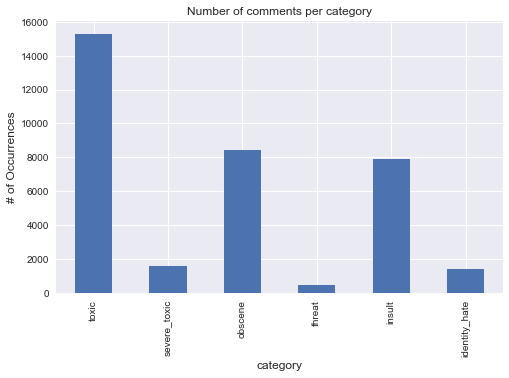

In [4]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Multi-Label
How many comments have multiple labels?



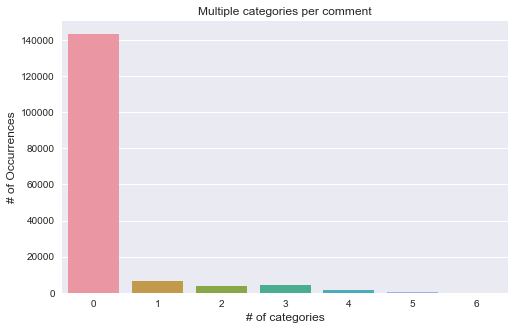

In [5]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

# Vast majority of the comment texts are not labeled.
# The distribution of the number of words in comment texts.

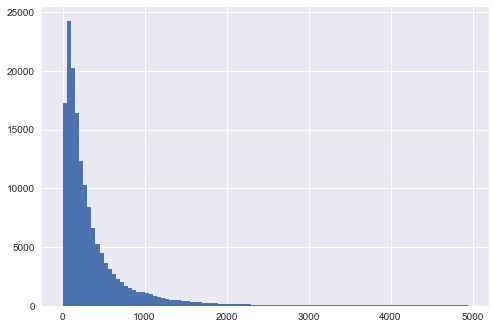

In [6]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

# Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.

In [7]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8983211235124177


# There is no missing comment in comment text column.



In [8]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

# Have a peek the first comment, the text needs clean.



In [9]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a function to clean the text


In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# Clean up comment_text column


In [12]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

Much better!


In [13]:
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

# Split to train and test sets

In [14]:
train, test = train_test_split(df, random_state=42, test_size=0.33)

In [15]:
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(106912,)
(52659,)


# Pipeline
scikit-learn provides a Pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

# OneVsRest multilabel strategy
The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

# Naive Bayes
OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.

In [23]:
# Define a pipeline combining a text feature extractor with multi lable classifier using TfidfVectorizer
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
# Define a pipeline combining a text feature extractor with multi lable classifier using CountVectorizer
NB_pipeline = Pipeline([
                ('countvect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])


In [24]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9165764636624318
... Processing severe_toxic
Test accuracy is 0.9900112041626312
... Processing obscene
Test accuracy is 0.9502269317685486
... Processing threat
Test accuracy is 0.9971135038644866
... Processing insult
Test accuracy is 0.9512523975009021
... Processing identity_hate
Test accuracy is 0.9910556600011394


# LinearSVC

In [27]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
SVC_pipeline = Pipeline([
                ('countvect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])


In [28]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9600068364382157
... Processing severe_toxic
Test accuracy is 0.9906948479842003
... Processing obscene
Test accuracy is 0.9788830019559809
... Processing threat
Test accuracy is 0.9974363356691164
... Processing insult
Test accuracy is 0.971135038644866
... Processing identity_hate
Test accuracy is 0.9919861752027194


# Logistic Regression

In [29]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
LogReg_pipeline = Pipeline([
                ('countvect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9548415275641391
... Processing severe_toxic
Test accuracy is 0.9910746501072941
... Processing obscene
Test accuracy is 0.9760724662450863
... Processing threat
Test accuracy is 0.9973603752444976
... Processing insult
Test accuracy is 0.9687422852693747
... Processing identity_hate
Test accuracy is 0.991758293928863


# Test for Checking if vectors are generated for japanese words

In [28]:
documents = ['診多索いほ', '診多索いほ', '台話辞ゃに']

vectorizer = TfidfVectorizer(stop_words=stop_words)#ngram_range=(1,1)
tfidf = vectorizer.fit_transform(documents)


In [29]:
# documents = ['診多索いほ', '診多索いほ', '台話辞ゃに']

# vectorizer = CountVectorizer()#ngram_range=(1,1)
# tfidf = vectorizer.fit_transform(documents)


In [30]:
vectorizer.vocabulary_

{'台話辞ゃに': 0, '診多索いほ': 1}

In [31]:
vectorizer.idf_

array([ 1.69314718,  1.28768207])